# Research Question
From the observed data in Monkey ECoG, we decided to investigate in the temporal region. Is there a significant difference between **theta waves (4-10Hz)** and **delta waves (0.5-4Hz)** during eyes closed (resting state) and anesthesia in the temporal lobe of the brain?
### By: Guillermo Rios Martinez, Zhi Chong Chris Lin, Jiawei Zheng, Zhuojun Chen

- Anesthesia is used in various medical procedures to put a patient into a sleep state so doctors can complete some type of procedure. Anesthesia is given to the patient through a breathing mask or IV line where they will eventually induce an unconscious state.
- Sleep has different stages that lead up to Rapid Eye Movement (REM). We wanted to look at the differences between sleep and anesthesia in regards to brain activity. Since the data we collected did not include sleep ECoG data, we decided to compare Stage 1 of sleep which is a resting state that can be similar to the monkey awake, with its eyes closed. 
- We decided to focus on the temporal region because we wanted to see if there was any changes in auditory functions during anesthesia and during a resting state. We assumed there would be very small changes between anesthetic and rest state in the occipital region because both states are not receiving any visual input. 

## Hypothesis: We believe there will be a significant difference between theta and delta waves during eyes closed and anesthesia in the temporal lobe of the brain.

# Background

- Based on a reading, "Low-frequency (<1 Hz) oscillations in the human sleep electroencephalogram", low-frequency oscillations were first reported in an anaesthetized cat and then during natural sleep. 
- "Anesthesia and Sleep" states that sleep and anesthesia may be more similar than previously thought. It is oberved that anesthesia activates neural networks normally involved in sleep. The studies were conducted on rats. It is theorized that this is the reason there is variability among anesthetic reactions amongst patients. 
- In, "The sedative component of anesthesia is mediated by GABA (A) receptors in an endogenous sleep pathway", GABA is observed to increase the frequencies in the temporal region of the brain. Anesthesia inhibits GABA which results in lower frequencies in the temproral region when under the anesthetic. (Below is a graph from this paper showing how GABA is affected with certain anesthetics)

<img src="diagram1.png" alt="Drawing" style="width: 600px;"/>

<img src="diagram2.png" alt="Drawing" style="width: 300px;"/>

# Methods

- Analyzing the Power Spectrum 
- Using STFT to compute the Spectrogram
- Adopting Welch's Method to find Power Spectral Density
- Utilizing Bandpass filters and Hilbert transform to compute instantaneous power and phase

# Imports

In [1]:
%matplotlib inline
from scipy import io, signal
import numpy as np
import matplotlib.pyplot as plt

# Monkey Resting ECoG Data
Recorded from monkey whole cortex. ECoG sampled at 1000Hz, 3 channels. From **Yanagawa et al., PLOS ONE, 2013.**

In this experiment, the monkey is sitting in a chair with no task demands. 5 minutes of data each are provided during 3 different stages: awake eyes open, awake eyes closed, and anesthesized. They are stored in `ecog_eyesopen`,`ecog_eyesclosed`, and `ecog_anes` respectively. The sampling rate is provided, from which you can compute the time vectors (they can have their own time vectors all starting from 0s).

`labels` contains information about which brain regions the 3 channels are located in, while `elec_num` has the electrode number, which you can find on the brain map image included in the same folder (brainmap.jpg).

In [2]:
monkey_ecog_data = io.loadmat('ECoG_monkey/ECoG_monkey.mat', squeeze_me = True)
print(monkey_ecog_data.keys())
print('FS:', monkey_ecog_data['fs'])
print(monkey_ecog_data['ecog_eyesopen'].shape)
print(monkey_ecog_data['labels'])
print(monkey_ecog_data['elec_num'])

fs = monkey_ecog_data['fs']

dict_keys(['__header__', '__version__', '__globals__', 'ecog_anes', 'ecog_eyesclosed', 'ecog_eyesopen', 'elec_num', 'fs', 'labels'])
FS: 1000
(3, 300000)
['cingulate' 'occipital' 'temporal']
[52 70 91]


# Monkey: Awake Eyes Open

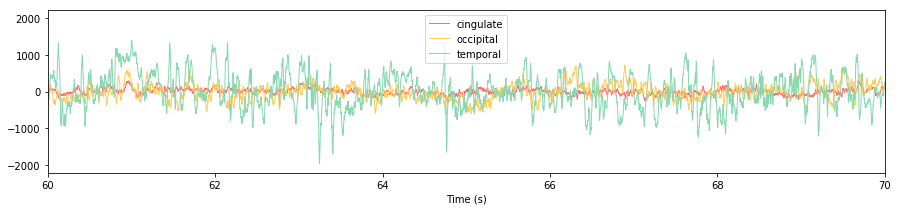

In [3]:
T_eyesopen = np.arange(0,monkey_ecog_data['ecog_eyesopen'].shape[1]/monkey_ecog_data['fs'],1/monkey_ecog_data['fs'])

plt.figure(figsize=(15,3))
plt.plot(T_eyesopen, monkey_ecog_data['ecog_eyesopen'][0].T, label="cingulate", color="#ff6f69", lw=1)
plt.plot(T_eyesopen, monkey_ecog_data['ecog_eyesopen'][1].T, label="occipital", color="#ffcc5c", lw=1)
plt.plot(T_eyesopen, monkey_ecog_data['ecog_eyesopen'][2].T, label="temporal", color="#88d8b0", lw=1)
plt.xlim([0+60,10+60])
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Monkey: Awake Eyes Closed

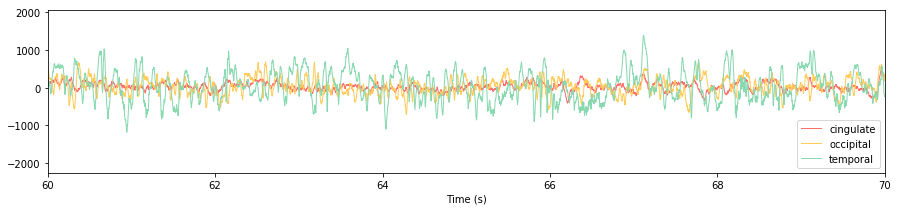

In [4]:
T_eyesclosed = np.arange(0,monkey_ecog_data['ecog_eyesclosed'].shape[1]/monkey_ecog_data['fs'],1/monkey_ecog_data['fs'])

plt.figure(figsize=(15,3))
plt.plot(T_eyesclosed, monkey_ecog_data['ecog_eyesclosed'][0].T, label="cingulate", color="#ff6f69", lw=1)
plt.plot(T_eyesclosed, monkey_ecog_data['ecog_eyesclosed'][1].T, label="occipital", color="#ffcc5c", lw=1)
plt.plot(T_eyesclosed, monkey_ecog_data['ecog_eyesclosed'][2].T, label="temporal", color="#88d8b0", lw=1)
plt.xlim([0+60,10+60])
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Monkey: Anesthesized

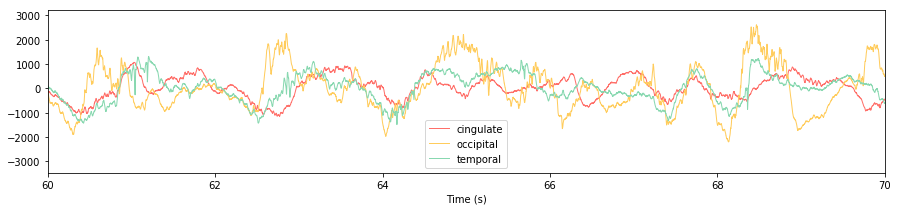

In [5]:
T_anes = np.arange(0,monkey_ecog_data['ecog_anes'].shape[1]/monkey_ecog_data['fs'],1/monkey_ecog_data['fs'])

plt.figure(figsize=(15,3))
plt.plot(T_anes, monkey_ecog_data['ecog_anes'][0].T, label="cingulate", color="#ff6f69", lw=1)
plt.plot(T_anes, monkey_ecog_data['ecog_anes'][1].T, label="occipital", color="#ffcc5c", lw=1)
plt.plot(T_anes, monkey_ecog_data['ecog_anes'][2].T, label="temporal", color="#88d8b0", lw=1)
plt.xlim([0+60,10+60])
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Analyze the Power Spectrum

In [6]:
def plot_pwsp(freqs, pwsp):
 plt.plot(freqs, pwsp)
 plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)');

# Power Spectrum of Monkey Eyes Open

In [7]:
fft_eyesopen = np.fft.fft(monkey_ecog_data['ecog_eyesopen'].T)
pwsp_eyesopen = np.abs(fft_eyesopen)**2
freqs_eyesopen = np.fft.fftfreq(len(monkey_ecog_data['ecog_eyesopen'].T), 1/fs)

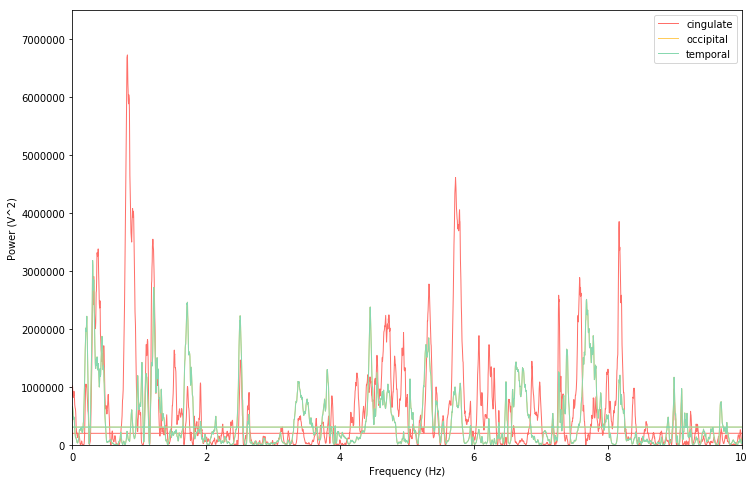

In [8]:
plt.figure(figsize=(12,8))
plt.plot(freqs_eyesopen, pwsp_eyesopen[:,0], label="cingulate", color="#ff6f69", lw=1)
plt.plot(freqs_eyesopen, pwsp_eyesopen[:,1], label="occipital", color="#ffcc5c", lw=1)
plt.plot(freqs_eyesopen, pwsp_eyesopen[:,2], label="temporal", color="#88d8b0", lw=1)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)');
plt.legend(monkey_ecog_data['labels'])
plt.xlim([0,10]),plt.ylim([0, 7500000])
plt.show()

# Power Spectrum of Monkey Eyes Closed

In [9]:
fft_eyesclosed = np.fft.fft(monkey_ecog_data['ecog_eyesclosed'].T)
pwsp_eyesclosed = np.abs(fft_eyesclosed)**2
freqs_eyesclosed = np.fft.fftfreq(len(monkey_ecog_data['ecog_eyesclosed'].T), 1/fs)

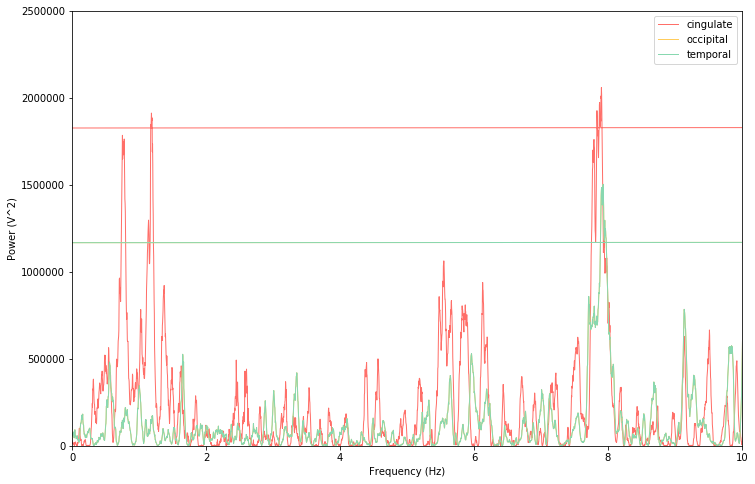

In [10]:
plt.figure(figsize=(12,8))
plt.plot(freqs_eyesclosed, pwsp_eyesclosed[:,0], label="cingulate", color="#ff6f69", lw=1)
plt.plot(freqs_eyesclosed, pwsp_eyesclosed[:,1], label="occipital", color="#ffcc5c", lw=1)
plt.plot(freqs_eyesclosed, pwsp_eyesclosed[:,2], label="temporal", color="#88d8b0", lw=1)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)');
plt.legend(monkey_ecog_data['labels'])
plt.xlim([0,10]),plt.ylim([0, 2500000])
plt.show()

# Power Spectrum of Monkey Anesthesized

In [11]:
fft_anes = np.fft.fft(monkey_ecog_data['ecog_anes'].T)
pwsp_anes = np.abs(fft_anes)**2
freqs_anes = np.fft.fftfreq(len(monkey_ecog_data['ecog_anes'].T), 1/fs)

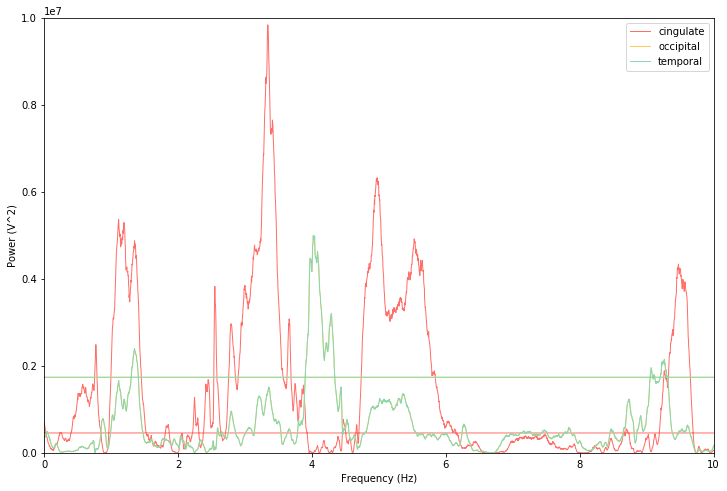

In [12]:
plt.figure(figsize=(12,8))
plt.plot(freqs_anes, pwsp_anes[:,0], label="cingulate", color="#ff6f69", lw=1)
plt.plot(freqs_anes, pwsp_anes[:,1], label="occipital", color="#ffcc5c", lw=1)
plt.plot(freqs_anes, pwsp_anes[:,2], label="temporal", color="#88d8b0", lw=1)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)');
plt.legend(monkey_ecog_data['labels'])
plt.xlim([0,10]),plt.ylim([0, 10000000])
plt.show()

# Spectrogram

Using the STFT computed, we've plotted the spectrogram (normalized/spectral density), and PSD.

In [13]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

In [14]:
len_win = 1
len_overlap = 0.5

In [15]:
def spectrogram_data (data):
    return signal.spectrogram(data, fs, window='rect', nperseg=int(fs*len_win), noverlap=int(fs*len_overlap), detrend=False)

## Temporal Region

In [16]:
# Extracting temporal data from different brain regions
temp_anes = monkey_ecog_data['ecog_anes'][2]
temp_eyesclosed = monkey_ecog_data['ecog_eyesclosed'][2]
temp_eyesopen = monkey_ecog_data['ecog_eyesopen'][2]

/Users/zhuojun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Text(0.5, 15.0, 'Time (s)')

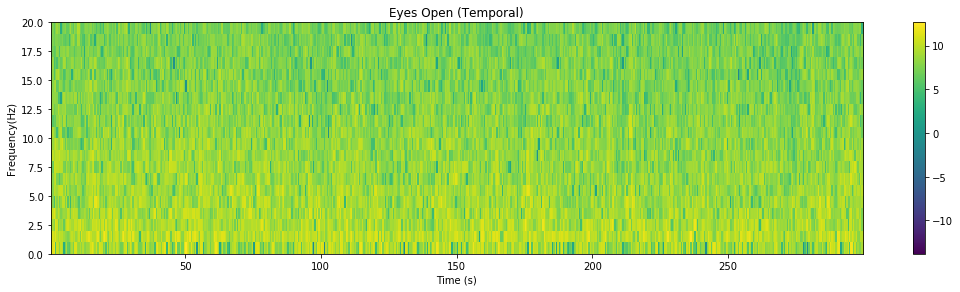

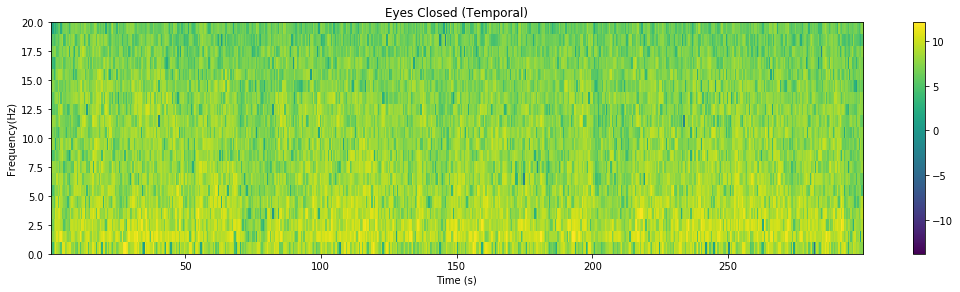

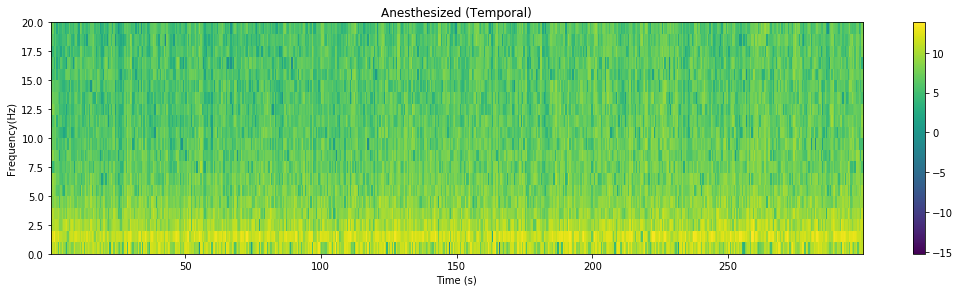

In [17]:
# Log scale
f_sp, t_sp, open_sp = spectrogram_data(temp_eyesopen)
plot_spectrogram(np.log(open_sp), t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Eyes Open (Temporal)');
plt.xlabel('Time (s)')
f_sp, t_sp, closed_sp = spectrogram_data(temp_eyesclosed)
plot_spectrogram(np.log(closed_sp), t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Eyes Closed (Temporal)');
plt.xlabel('Time (s)')
f_sp, t_sp, anes_sp = spectrogram_data(temp_anes)
plot_spectrogram(np.log(anes_sp), t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Anesthesized (Temporal)');
plt.xlabel('Time (s)')

### Observation
- Signal frequencies are in the same range when computed in log scale

Text(0.5, 15.0, 'Time (s)')

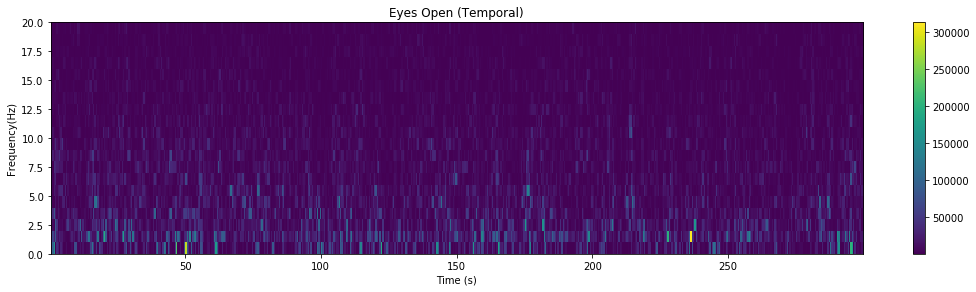

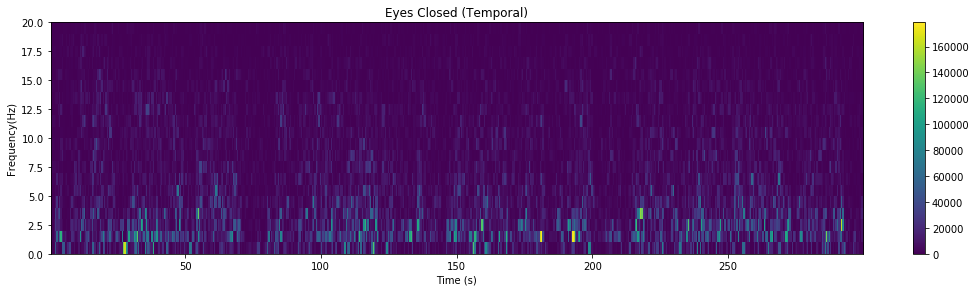

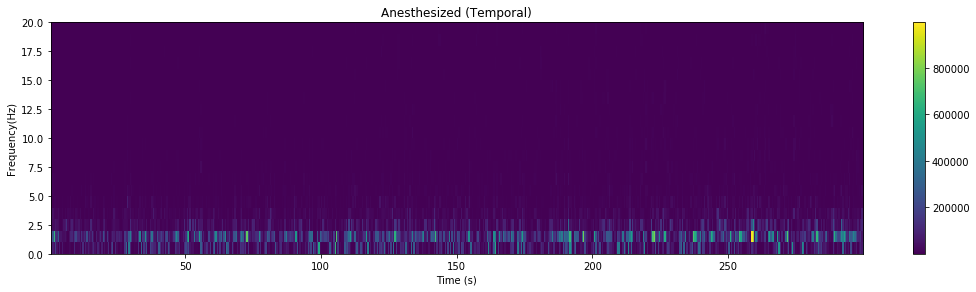

In [18]:
# Numerical Scale - for clearer color contrast visualization
f_sp, t_sp, open_sp = spectrogram_data(temp_eyesopen)
plot_spectrogram(open_sp, t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Eyes Open (Temporal)');
plt.xlabel('Time (s)')
f_sp, t_sp, closed_sp = spectrogram_data(temp_eyesclosed)
plot_spectrogram(closed_sp, t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Eyes Closed (Temporal)');
plt.xlabel('Time (s)')
f_sp, t_sp, anes_sp = spectrogram_data(temp_anes)
plot_spectrogram(anes_sp, t_sp, f_sp, freq_lims=[0,20], plot_db=False)
plt.title('Anesthesized (Temporal)');
plt.xlabel('Time (s)')

### Observation
- Choice of parameter: len_win = 1; len_overlap = 0.5
    - higher temporal resolution to visualize changes within 5 min
- Eyes open: fluctuation in different frequencies over 5 min
    - lower frequencies (0 - 5 Hz) shows stronger signal 
    - no concrete pattern in varying frequencies
    - signal frequency varies from (0 - 300000)
- Eyes closed: fluctuation in different frequencies over 5 min
    - similar to the status when eyes are open
    - signal frequency is about half of when eyes are open (0 - 160000)
- Anesthesized: 
    - relatively constant frequency (0 - 3 Hz)
    - initially, weak signs of lower frequencies (0 - 2 Hz)
    - as time passes, frequency signals become stronger and higher frequencies(2 - 3 Hz) become present 
    - signal frequency is about half of when eyes are closed (0 - 80000)

## Anesthesized monkey's Temporal vs Occipital vs Cingulate Region

In [ ]:
# Extracting occipital data from different brain regions
cin_anes = monkey_ecog_data['ecog_anes'][0]
occ_anes = monkey_ecog_data['ecog_anes'][1]
temp_anes = monkey_ecog_data['ecog_anes'][2]

Text(0.5, 15.0, 'Time (s)')

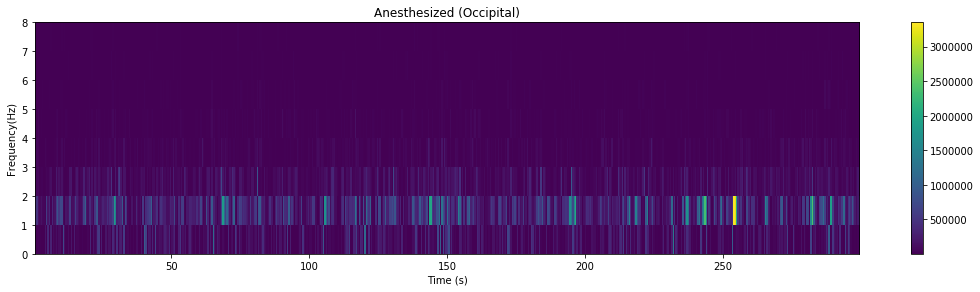

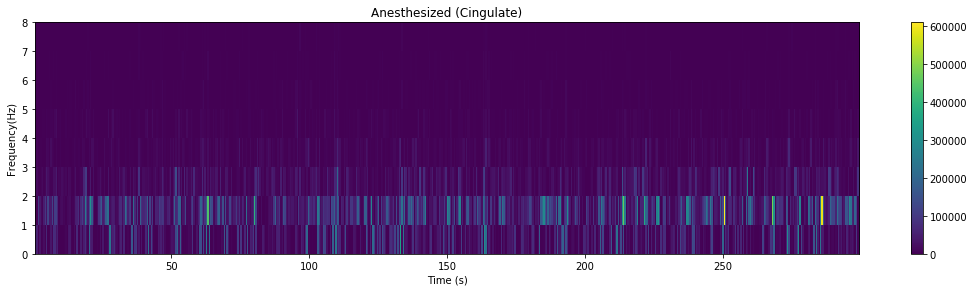

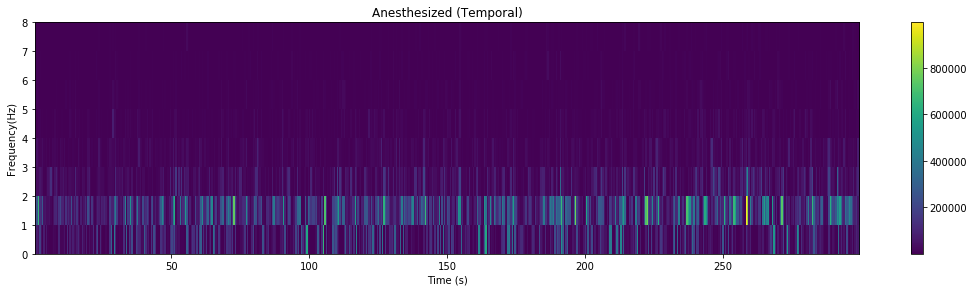

In [ ]:
f_sp, t_sp, anes_sp = spectrogram_data(occ_anes)
plot_spectrogram(anes_sp, t_sp, f_sp, freq_lims=[0,8], plot_db=False)
plt.title('Anesthesized (Occipital)');
plt.xlabel('Time (s)')
f_sp, t_sp, anes_sp = spectrogram_data(cin_anes)
plot_spectrogram(anes_sp, t_sp, f_sp, freq_lims=[0,8], plot_db=False)
plt.title('Anesthesized (Cingulate)');
plt.xlabel('Time (s)')
f_sp, t_sp, anes_sp = spectrogram_data(temp_anes)
plot_spectrogram(anes_sp, t_sp, f_sp, freq_lims=[0,8], plot_db=False)
plt.title('Anesthesized (Temporal)');
plt.xlabel('Time (s)')

### Observation
- Zoomed into the frequencies of (0 - 8 Hz)
- Increasing power as time passes
    - Weaker in the first 50 seconds
    - Strongest in the last 100 seconds
- Constant dominant frequency throughout the regions (1 - 2 Hz)

### Intuition
- From study "Temporal Characteristics of the Sleep EEG Power Spectrum in Critically Ill Children":
    - Healthy children demonstrates well-characterized temporal pattern of slow wave activity (EEG δ power) activity when asleep, with a significant concentration of δ power in the first NREM period, which generally occurs within the first two hours after sleep onset.
    - The above statement is consistent with our observation that dominant frequency waves are found when the monkey is in its anesthesized state. The experiment time of 5 minutes also relates to the first NREM period.

# Power Spectrum in the Temporal Region - Anesthesized vs Eyes Closed

Now we'll go over the power spectrum of a signal, which is the squared magnitude of the complex vector at every frequency. This representation tells us which components are the strongest (has the highest power) in our data.

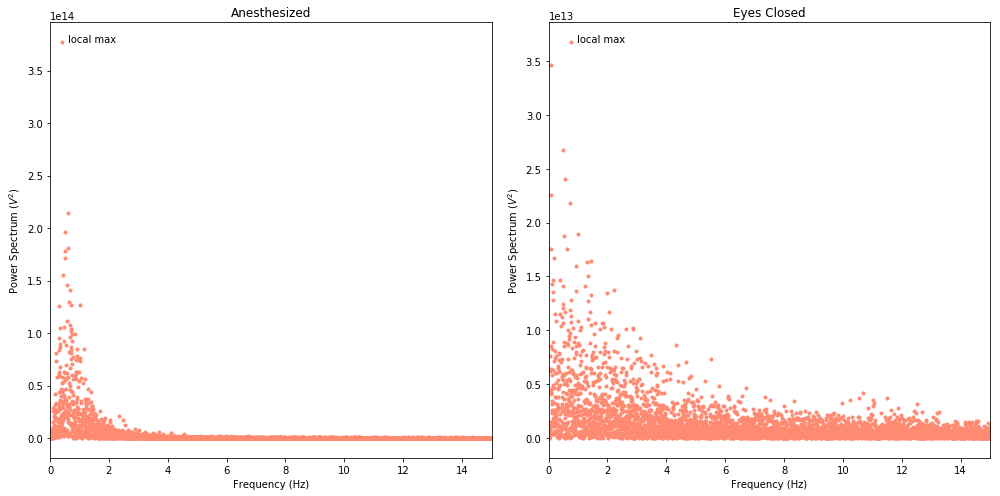

In [ ]:
N_anes = len(temp_anes)
freqs_anes = np.fft.fftfreq(N_anes, 1/fs)
F_lfp_anes = np.fft.fft(temp_anes)
power_anes = np.abs(F_lfp_anes)**2

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(freqs_anes, power_anes, '.', label='numpy Power', color="#fe8a71")
plt.xlabel('Frequency (Hz)');plt.ylabel('Power Spectrum ($V^2$)')
plt.xlim([0,15])
plt.title('Anesthesized')

ymax = max(power_anes)
xpos = list(power_anes).index(ymax)
xmax = freqs_anes[xpos]

plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax +0.2, ymax))

N_closed = len(temp_eyesclosed)
freqs_closed = np.fft.fftfreq(N_closed, 1/fs)
F_lfp_closed = np.fft.fft(temp_eyesclosed)
power_closed = np.abs(F_lfp_closed)**2

plt.subplot(1,2,2)
plt.plot(freqs_closed, power_closed, '.', color="#fe8a71")
plt.xlabel('Frequency (Hz)');plt.ylabel('Power Spectrum ($V^2$)')
plt.xlim([0,15])
plt.title('Eyes Closed')

ymax = max(power_closed)
xpos = list(power_closed).index(ymax)
xmax = freqs_closed[xpos]

plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax +0.2, ymax))
plt.tight_layout()

### Observation
- Choice of parameter: frequency window limited from 0 - 20 Hz
- Similarities: Stronger power in lower frequencies
    - Right skewed distribution for both
- Differences:
    - During anesthesized, frequencies above 2 show an instant decline in power
    - During eyes closed (resting), frequencies above 2 also indicates a decline, but much more noisier than the previous

# Power Spectrum of the Anesthesized Monkey in different regions

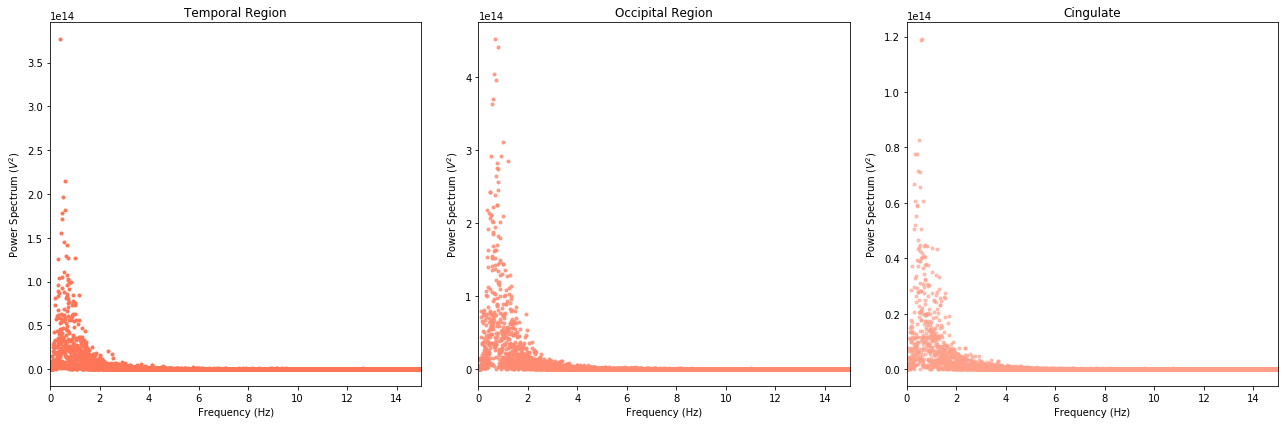

In [ ]:
N_temp = len(temp_anes)
freqs_temp = np.fft.fftfreq(N_temp, 1/fs)
F_lfp_temp = np.fft.fft(temp_anes)
power_temp = np.abs(F_lfp_temp)**2

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(freqs_temp, power_temp, '.', color="#fe7558")
plt.xlabel('Frequency (Hz)');plt.ylabel('Power Spectrum ($V^2$)')
plt.xlim([0,15])
plt.title('Temporal Region')

N_occ = len(occ_anes)
freqs_occ = np.fft.fftfreq(N_occ, 1/fs)
F_lfp_occ = np.fft.fft(occ_anes)
power_occ = np.abs(F_lfp_occ)**2

plt.subplot(1,3,2)
plt.plot(freqs_occ, power_occ, '.', color="#fe8a71", alpha = 0.8)
plt.xlabel('Frequency (Hz)');plt.ylabel('Power Spectrum ($V^2$)')
plt.xlim([0,15])
plt.title('Occipital Region')

N_cin = len(cin_anes)
freqs_cin = np.fft.fftfreq(N_cin, 1/fs)
F_lfp_cin = np.fft.fft(cin_anes)
power_cin = np.abs(F_lfp_cin)**2

plt.subplot(1,3,3)
plt.plot(freqs_cin, power_cin, '.',  color="#fe9f8a", alpha = 0.6)
plt.xlabel('Frequency (Hz)');plt.ylabel('Power Spectrum ($V^2$)')
plt.xlim([0,15])
plt.title('Cingulate')

plt.tight_layout()

### Observation
- Similarities: Stronger power in lower frequencies & weak power in higher frequencies (almost a flat line)
- Differences:
    - Temporal region shows almost 0 activity above 2Hz
    - Power in the cingulate region is on a weaker scale than the temporal region and the occipital region

### Intuition
- "Low-frequency (<1 Hz) oscillations in the human sleep electroencephalogram", low-frequency oscillations were first reported in an anaesthetized cat and then during natural sleep
- From Regional low-frequency oscillations in human rapid-eye movement sleep:
    - A cluster of low frequency oscillations consisted of occipital slow waves (<2 Hz). This finding is consistent with previous work, describing the maximal peak of low-delta activity in occipital areas.
    - Our observation of local occipital slow waves is consistent with the hypothesis that slow waves in primary cortices could be responsible for sensory disconnection during sleep

## Welch's PSD (Anesthesized - Temporal) in log-scale

/Users/zhuojun/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1441: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


Text(1.2, 173202.62, 'local max')

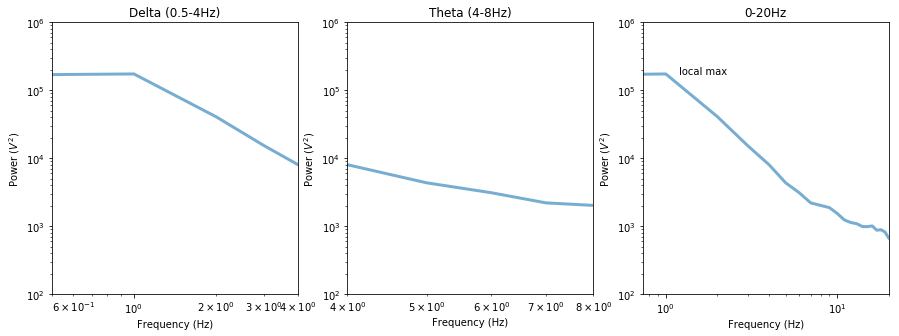

In [ ]:
len_win = 1
len_overlap = 0.5
f_anes, p_anes = signal.welch(temp_anes,fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Delta (0.5-4Hz)')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_anes, p_anes, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0.5, 4])
plt.ylim([10**2,10**6])

plt.subplot(1,3,2)
plt.title('Theta (4-8Hz)')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_anes, p_anes, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([4, 8])
plt.ylim([10**2,10**6])

plt.subplot(1,3,3)
plt.title('0-20Hz')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_anes, p_anes, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0, 20])
plt.ylim([10**2,10**6])

ymax = max(p_anes)
xpos = list(p_anes).index(ymax)
xmax = f_anes[xpos]

plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax +0.2, ymax))


In [ ]:
# Dominant Frequency
print(list(p_anes).index(max(p_anes)))

1


### Observation
- Choice of scale: log-scale to more accurately describe the trend between power and frequency
- Declining trend from 0 - 20 Hz
- Dominant frequency from 0.5 - 2Hz

## Welch's PSD (Eyes Closed - Temporal) in log-scale

(100, 1000000)

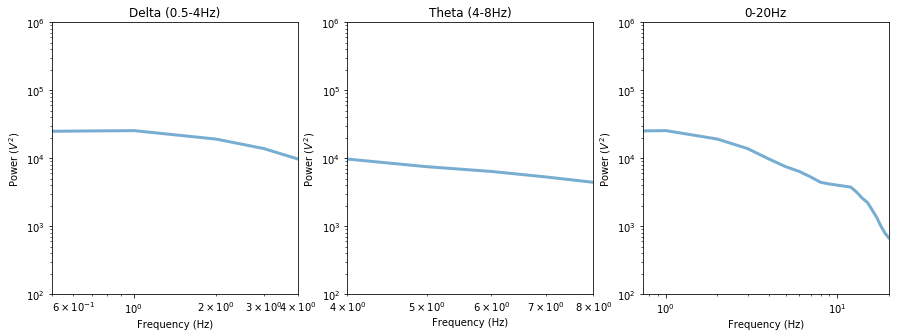

In [ ]:
len_win = 1
len_overlap = 0.5
f_closed, p_closed = signal.welch(temp_eyesclosed,fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Delta (0.5-4Hz)')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_closed, p_closed, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0.5, 4])
plt.ylim([10**2,10**6])

plt.subplot(1,3,2)
plt.title('Theta (4-8Hz)')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_closed, p_closed, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([4, 8])
plt.ylim([10**2,10**6])

plt.subplot(1,3,3)
plt.title('0-20Hz')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_closed, p_closed, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0, 20])
plt.ylim([10**2,10**6])

In [ ]:
# Dominant Frequency
print(list(p_closed).index(max(p_closed)))

1


### Observation
- Choice of scale: log-scale to more accurately describe the trend between power and frequency
- Declining trend from 0 - 20 Hz (much faster in higher frequencies than anesthesized)
- Dominant frequency in lower waves

### Comparing Welch's PSD in Temporal Region: Anesthesized vs Eyes Closed in Delta Range (0.5 - 4Hz)

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Eyes Closed')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_closed, p_closed, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0.5, 4])
plt.ylim([10**3,10**6])

plt.subplot(1,2,2)
plt.title('Anesthesized')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power ($V^2$)')
plt.loglog(f_anes, p_anes, label = 'welch PSD', alpha = 0.6, lw=3)
plt.xlim([0.5, 4])
plt.ylim([10**3,10**6])

(1000, 1000000)

In [ ]:
# unpack the variables
fs = monkey_ecog_data['fs'] # sampling rate 
labels = monkey_ecog_data['labels']
print('Sampling rate = %iHz'%fs)

# the data for awake eyes open, awake eye closed and anesthesized
ecog_eyesopen = monkey_ecog_data['ecog_eyesopen']
ecog_eyesclosed = monkey_ecog_data['ecog_eyesclosed']
ecog_anes = monkey_ecog_data['ecog_anes']

# the total time (5 minutes) for awake eyes closed and anesthesized
T = np.arange(0,ecog_eyesclosed.shape[1]/fs,1/fs)

# Hilbert Transformation 
In this section, we create a filter to filter the signal to constrain the signal bandwidth to two particular frequency ranges(the delta frequency and the theta frequency)

Zoom into the first 30 seconds of the data for all the plots below.

- Design a 1000-point **bandpass filter** that has a passband of 4-8 Hz and store the coefficients in the variable `theta_filter`.
- Use np.convolve() to filter the ecog_eyesclosed signal in temporal, time, and store it in the variable `theta_osc`. Plot both the original and bandpass filtered signal in the same plot. Zoom into the first 2 seconds.
- Compute the analytic signal of the filtered oscillation, and plot the filtered signal, real and imaginary components of it in the same plot. 
- amplitude = signal envelope of the sinusoid and phase is the phase

In [ ]:
# compute the power and phase
def compute_power_phase(x_a):
    power = np.abs(x_a)**2
    phase = np.angle(x_a)
    return power, phase

In [ ]:
# calculate the instantaneus rate of change
def derivative(freq, phase):
    der = []
    for i in range(len(phase)-1):
        d = (phase[i+1]-phase[i]) / (freq[i+1] -freq[i])
        der.append(d)
    return np.array(der)   

## Theta Filter

In [ ]:
# the theta filter
theta_filter = signal.firwin(1000, cutoff= [4, 10], fs=fs, pass_zero = False)

### Compute the hilbert transformation of the temporal signal when monkey is awake eyes open

In [ ]:
# the theta osccilation when awake eyes open
theta_osc_tem_open = np.convolve(ecog_eyesopen.T[:,2], theta_filter, mode = 'same')
theta_x_a_tem_open = signal.hilbert(theta_osc_tem_open)

# the theta phase and theta power when awake eyes closed
theta_power_tem_open, theta_phase_tem_open = compute_power_phase(theta_x_a_tem_open)

### Compute the hilbert transformation of the temporal signal when monkey is awake eyes closed

In [ ]:
# the theta osccilation when awake eyes closed
theta_osc_tem_closed = np.convolve(ecog_eyesclosed.T[:,2], theta_filter, mode = 'same')
theta_x_a_tem_closed = signal.hilbert(theta_osc_tem_closed)

# the theta phase and theta power when awake eyes closed
theta_power_tem_closed, theta_phase_tem_closed = compute_power_phase(theta_x_a_tem_closed)

### Compute the hilbert transformation of the temporal signal when monkey is anesthesized

In [ ]:
theta_osc_tem_anes = np.convolve(ecog_anes.T[:,2], theta_filter, mode = 'same')
theta_x_a_tem_anes = signal.hilbert(theta_osc_tem_anes)

theta_power_tem_anes, theta_phase_tem_anes = compute_power_phase(theta_x_a_tem_anes)

In [ ]:
plt.figure(figsize=(15,10))

# plot orignal the signal and the bandpass filtered signal
plt.subplot(4,1,1)
# plt.plot(T, theta_osc_tem_open, label= "Open", lw=1)
plt.plot(T, theta_osc_tem_closed, label= "Closed", lw=1)
plt.plot(T, theta_x_a_tem_anes, label= "Anesthesized", lw=1)
plt.xlabel('Time (s)'),plt.ylabel('Voltage(uV)')
plt.title("Filtered Temporal Signal")
plt.xlim([0,30])
plt.legend()


# plot the real and imaginary components of the analytic signal
plt.subplot(4,1,2)
# plt.plot(T, theta_x_a_tem_open.imag, label='Open', alpha=0.5, lw=2)
plt.plot(T, theta_x_a_tem_closed.imag, label='Closed', alpha=0.5, lw=2)
plt.plot(T, theta_x_a_tem_anes.imag, label='Anesthesized', alpha=0.5, lw=2)
plt.xlabel('Time (s)'); plt.ylabel('Analytic Signal')
plt.title("Hilbert Imaginary")
plt.xlim([0,30])
plt.legend()

# plot the instantaneous power 
plt.subplot(4,1,3)
# plt.plot(T, theta_power_tem_open, label= "Open")
plt.plot(T, theta_power_tem_closed, label= "Closed")
plt.plot(T, theta_power_tem_anes, label= "Anesthesized")
plt.xlabel('Time (s)'), plt.ylabel('Power (uV^2)')
plt.title("Instantaneous Power")
plt.xlim([120,150])
plt.legend()


# plot the instantaneous phase
plt.subplot(4,1,4)
# plt.plot(T, theta_phase_tem_open, '.', label= "Open", ms=1)
plt.plot(T, theta_phase_tem_closed, '.', label= "Closed", ms=1)
plt.plot(T, theta_phase_tem_anes, '.', label= "Anesthesized", ms=1)
plt.xlabel('Time (s)'), plt.ylabel('Angle')
plt.title("Instantaneous Phase")
plt.xlim([120,130])
plt.legend()

plt.tight_layout()

- when monkey is in the status of awake eyes closed, the theta wave is the edivident wave.
- consistent with the theta wave, occurs when people are in the deep relaxation and mediation.

plot the trace of the first 2 seconds of the analytic signal in the complex domain.

In [ ]:
plt.figure(figsize=(6,6))
plt.axhline(color='k', lw=1)
plt.axvline(color='k', lw=1)
plt.plot(theta_x_a_tem_closed.real[:2000], theta_x_a_tem_closed.imag[:2000], '.-', label="Closed", alpha=0.5, ms=2)
plt.plot(theta_x_a_tem_anes.real[:2000], theta_x_a_tem_anes.imag[:2000], '.-', label="Anesthesized", alpha=0.5, ms=2)
plt.xlabel('Real');plt.ylabel('Imaginary')
plt.legend()
plt.show()

## Delta Filter

In [ ]:
# the delta filter
delta_filter = signal.firwin(1000, cutoff= [0.5, 4], fs=fs, pass_zero = False)

### Compute the hilbert transformation of the temporal signal when monkey is awake eyes open

In [ ]:
# the delta osccilation when awake eyes open
delta_osc_tem_open = np.convolve(ecog_eyesopen.T[:,2], delta_filter, mode = 'same')
delta_x_a_tem_open = signal.hilbert(delta_osc_tem_open)

# the delta phase and delta power when awake eyes open
delta_power_tem_open, delta_phase_tem_open = compute_power_phase(delta_x_a_tem_open)

### Compute the hilbert transformation of the temporal signal when monkey is awake eyes closed

In [ ]:
# the delta osccilation when awake eyes closed
delta_osc_tem_closed = np.convolve(ecog_eyesclosed.T[:,2], delta_filter, mode = 'same')
delta_x_a_tem_closed = signal.hilbert(delta_osc_tem_closed)

# the delta phase and delta power when awake eyes closed
delta_power_tem_closed, delta_phase_tem_closed = compute_power_phase(delta_x_a_tem_closed)

### Compute the hilbert transformation of the temporal signal when monkey is anesthesized

In [ ]:
# the delta osccilation when anesthesized
delta_osc_tem_anes = np.convolve(ecog_anes.T[:,2], delta_filter, mode = 'same')
delta_x_a_tem_anes = signal.hilbert(delta_osc_tem_anes)

# the delta phase and delta power when anesthesized
delta_power_tem_anes, delta_phase_tem_anes = compute_power_phase(delta_x_a_tem_anes)

In [ ]:
plt.figure(figsize=(15,10))

# plot orignal the signal and the bandpass filtered signal
plt.subplot(4,1,1)
# plt.plot(T, delta_osc_tem_open, label= "Open", lw=1)
plt.plot(T, delta_osc_tem_closed, label= "Closed", lw=1)
plt.plot(T, delta_x_a_tem_anes, label= "Anesthesized", lw=1)
plt.xlabel('Time (s)'),plt.ylabel('Voltage(uV)')
plt.title("Filtered Temporal Signal")
plt.xlim([0,30])
plt.legend()


# plot the real and imaginary components of the analytic signal
plt.subplot(4,1,2)
# plt.plot(T, delta_x_a_tem_open.imag, label='Open', alpha=0.5, lw=2)
plt.plot(T, delta_x_a_tem_closed.imag, label='Closed', alpha=0.5, lw=2)
plt.plot(T, delta_x_a_tem_anes.imag, label='Anesthesized', alpha=0.5, lw=2)
plt.xlabel('Time (s)'); plt.ylabel('Analytic Signal')
plt.title("Hilbert Imaginary")
plt.xlim([0,30])
plt.legend()

# plot the instantaneous power 
plt.subplot(4,1,3)
# plt.plot(T, delta_power_tem_open, label= "Open")
plt.plot(T, delta_power_tem_closed, label= "Closed")
plt.plot(T, delta_power_tem_anes, label= "Anesthesized")
plt.xlabel('Time (s)'), plt.ylabel('Power (uV^2)')
plt.title("Instantaneous Power")
plt.xlim([120,150])
plt.legend()


# plot the instantaneous phase
plt.subplot(4,1,4)
# plt.plot(T, delta_phase_tem_open, '.', label= "Open", ms=1)
plt.plot(T, delta_phase_tem_closed, '.', label= "Closed", ms=1)
plt.plot(T, delta_phase_tem_anes, '.', label= "Anesthesized", ms=1)
plt.xlabel('Time (s)'), plt.ylabel('Angle')
plt.title("Instantaneous Phase")
plt.xlim([120,130])
plt.legend()

plt.tight_layout()

- when monkey is in the status of anesthesized, the delta wave is the edivident wave.
- consistent with the theta wave, occurs when people are in the deep and dreamless sleep.

plot the trace of the first 2 seconds of the analytic signal in the complex domain.

In [ ]:
plt.figure(figsize=(6,6))
plt.axhline(color='k', lw=1)
plt.axvline(color='k', lw=1)
plt.plot(delta_x_a_tem_closed.real[:2000], delta_x_a_tem_closed.imag[:2000], '.-', label="Closed", alpha=0.5, ms=2)
plt.plot(delta_x_a_tem_anes.real[:2000], delta_x_a_tem_anes.imag[:2000], '.-', label="Anesthesized", alpha=0.5, ms=2)
plt.xlabel('Real');plt.ylabel('Imaginary')
plt.legend()
plt.show()

# Coherence
#### Additional Attempt on Analysis

In [ ]:
# Trial times
time = np.arange(0,len(temp_anes)/fs,1/fs)

In [ ]:
def secs_to_points(fs, len_win, len_overlap):
    nperseg = len_win * fs #_YOUR_CODE_HERE
    noverlap = len_overlap * fs #_YOUR_CODE_HERE
    return int(nperseg), int(noverlap)

In [ ]:
# Use these length settings for STFT
nperseg, noverlap = secs_to_points(fs, len_win=2, len_overlap=1)
# Compute stft
f_stft, t_stft, stft = signal.stft(occ_anes, fs, nperseg = nperseg, noverlap = noverlap)
# Find the index (k) of 1Hz.
f_ind = np.where(f_stft == 1)
# Grab random slices of the STFT to compute coherence 
np.random.seed(0)
trial_inds = np.random.randint(0,len(t_stft), size=len(time))[:20]

In [ ]:
plt.figure(figsize=(5,5))
plt.xlabel('Real'); plt.ylabel('Imag')
# plot all trial vectors
normalized = []
for trial_ind in trial_inds:
    X_trial = stft[f_ind, trial_ind].squeeze()
    # normalize by vector length
    X_trial = X_trial/np.abs(X_trial) #_YOUR_CODE_HERE
    normalized.append(X_trial)
    plt.plot([0,X_trial.real], [0, X_trial.imag], 'k.--', alpha=0.3)
    
# plot mean vector
X_mean = np.mean(normalized)#_YOUR_CODE_HERE
plt.plot([0,X_mean.real], [0, X_mean.imag], 'ko-', label='Random mean')
coherence_random = np.abs(np.mean(normalized))#_YOUR_CODE_HERE
print("random coherence: " + str(coherence_random))

# Conclusion

There is a difference between theta and delta waves in the temporal region of the brain during two different states, resting state also known as eyes closed and anesthesia. We can see that theta waves are more prominent during resting state and delta is more dominant during the anesthetic state from our three neural signal analysis. 

# References

- https://www.ncbi.nlm.nih.gov/pubmed/9300413
- https://www.ncbi.nlm.nih.gov/pubmed/15144963
- https://www.nature.com/articles/nn913.pdf
- https://www.biorxiv.org/content/10.1101/397224v1.full
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4661338/

# Contributions

- We all worked together to accomplish the analyis and create this presentation.